In [2]:
import pymc3 as pm
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import patsy
from sklearn.preprocessing import normalize, MinMaxScaler

%load_ext autoreload
%autoreload 2
%matplotlib inline
%config InlineBackend.figure_format = 'retina'

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


# Introduction

**Multi-class Bayesian Logistic Regression**

The task at hand is to predict forest cover type from cartographic variables. See https://archive.ics.uci.edu/ml/datasets/covertype for more details. 

The purpose of this notebook is more to give an overview on how to do **multi-class logistic regression** using PyMC3.

# Data Pre-Processing

Firstly, let's read in the data.

In [3]:
# Read in the data.
data = pd.read_csv('datasets/covtype.data', header=None)

# Column 54 is the target variable, and we want it to be strings.
data[54] = data[54].apply(lambda x: str(x))

# Now, we rename the columns of the dataframe to make things easier for 
# downstream processing.
curr_cols = list(data.columns)
curr_cols[-1] = 'target'
data.columns = curr_cols

# # Finally, sample 10,000 points from the whole dataset.
# data = data.sample(10000)

## Target Variables

Firstly, let's get the target variables out as a multi-class table.

In [4]:
Y = patsy.dmatrix('target -1', data, return_type='dataframe')
Y.head()

,target[1],target[2],target[3],target[4],target[5],target[6],target[7]
0,0.0,0.0,0.0,0.0,1.0,0.0,0.0
1,0.0,0.0,0.0,0.0,1.0,0.0,0.0
2,0.0,1.0,0.0,0.0,0.0,0.0,0.0
3,0.0,1.0,0.0,0.0,0.0,0.0,0.0
4,0.0,0.0,0.0,0.0,1.0,0.0,0.0


## Class Imbalance

Is there class imbalance in the dataset? Let's check this to see if we need to do some downsampling.

In [5]:
Y.sum(axis=0)

target[1]    211840.0
target[2]    283301.0
target[3]     35754.0
target[4]      2747.0
target[5]      9493.0
target[6]     17367.0
target[7]     20510.0
dtype: float64

Yes, there is class imbalance. Target 4 is about 100X less than targets 1 and 2, and about 10X less than targets 6 and 7. Need to downsample to that size.

## Downsampling

We will downsample the data to just 2747 datapoints, and normalize the data using `scikit-learn`'s `normalize` function from the `sklearn.preprocessing` module.

In [6]:
downsampled_targets = []

for i in range(1, 7+1):
    # print(f'target[{i}]')
    target = Y[Y[f'target[{i}]'] == 1]
    # print(len(target))
    downsampled_targets.append(target.sample(2747))
    
mms = MinMaxScaler()
X = pm.floatX(mms.fit_transform(data[curr_cols[:-1]]))

Y_downsamp = pd.concat(downsampled_targets)
X_downsamp = X[Y_downsamp.index]

## Data Sanity Checks

Let's now check that the downsampled classes are indeed of the same shape.

In [7]:
Y_downsamp.sum()

target[1]    2747.0
target[2]    2747.0
target[3]    2747.0
target[4]    2747.0
target[5]    2747.0
target[6]    2747.0
target[7]    2747.0
dtype: float64

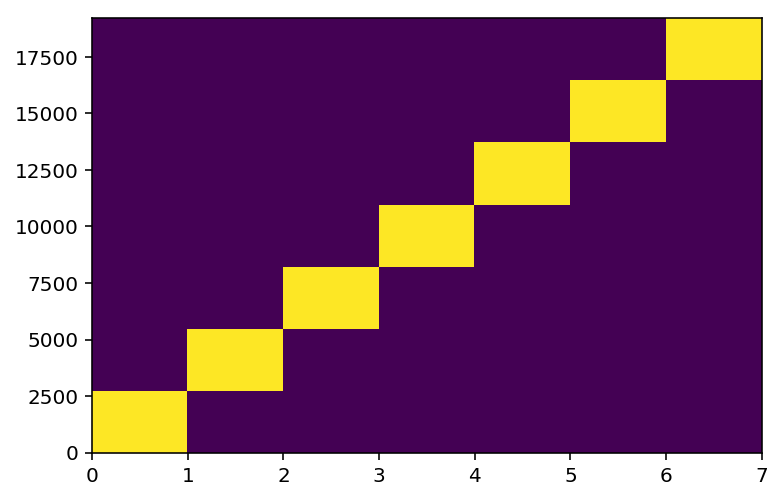

In [8]:
plt.pcolor(Y_downsamp)

In [9]:
X_downsamp.shape

(19229, 54)

In [10]:
Y_downsamp.shape

(19229, 7)

In [11]:
print(X.shape[1], Y.shape[1])

54 7


Also, let's visualize the distribution of data.

### Missing Data

Firstly, checking for missing values.

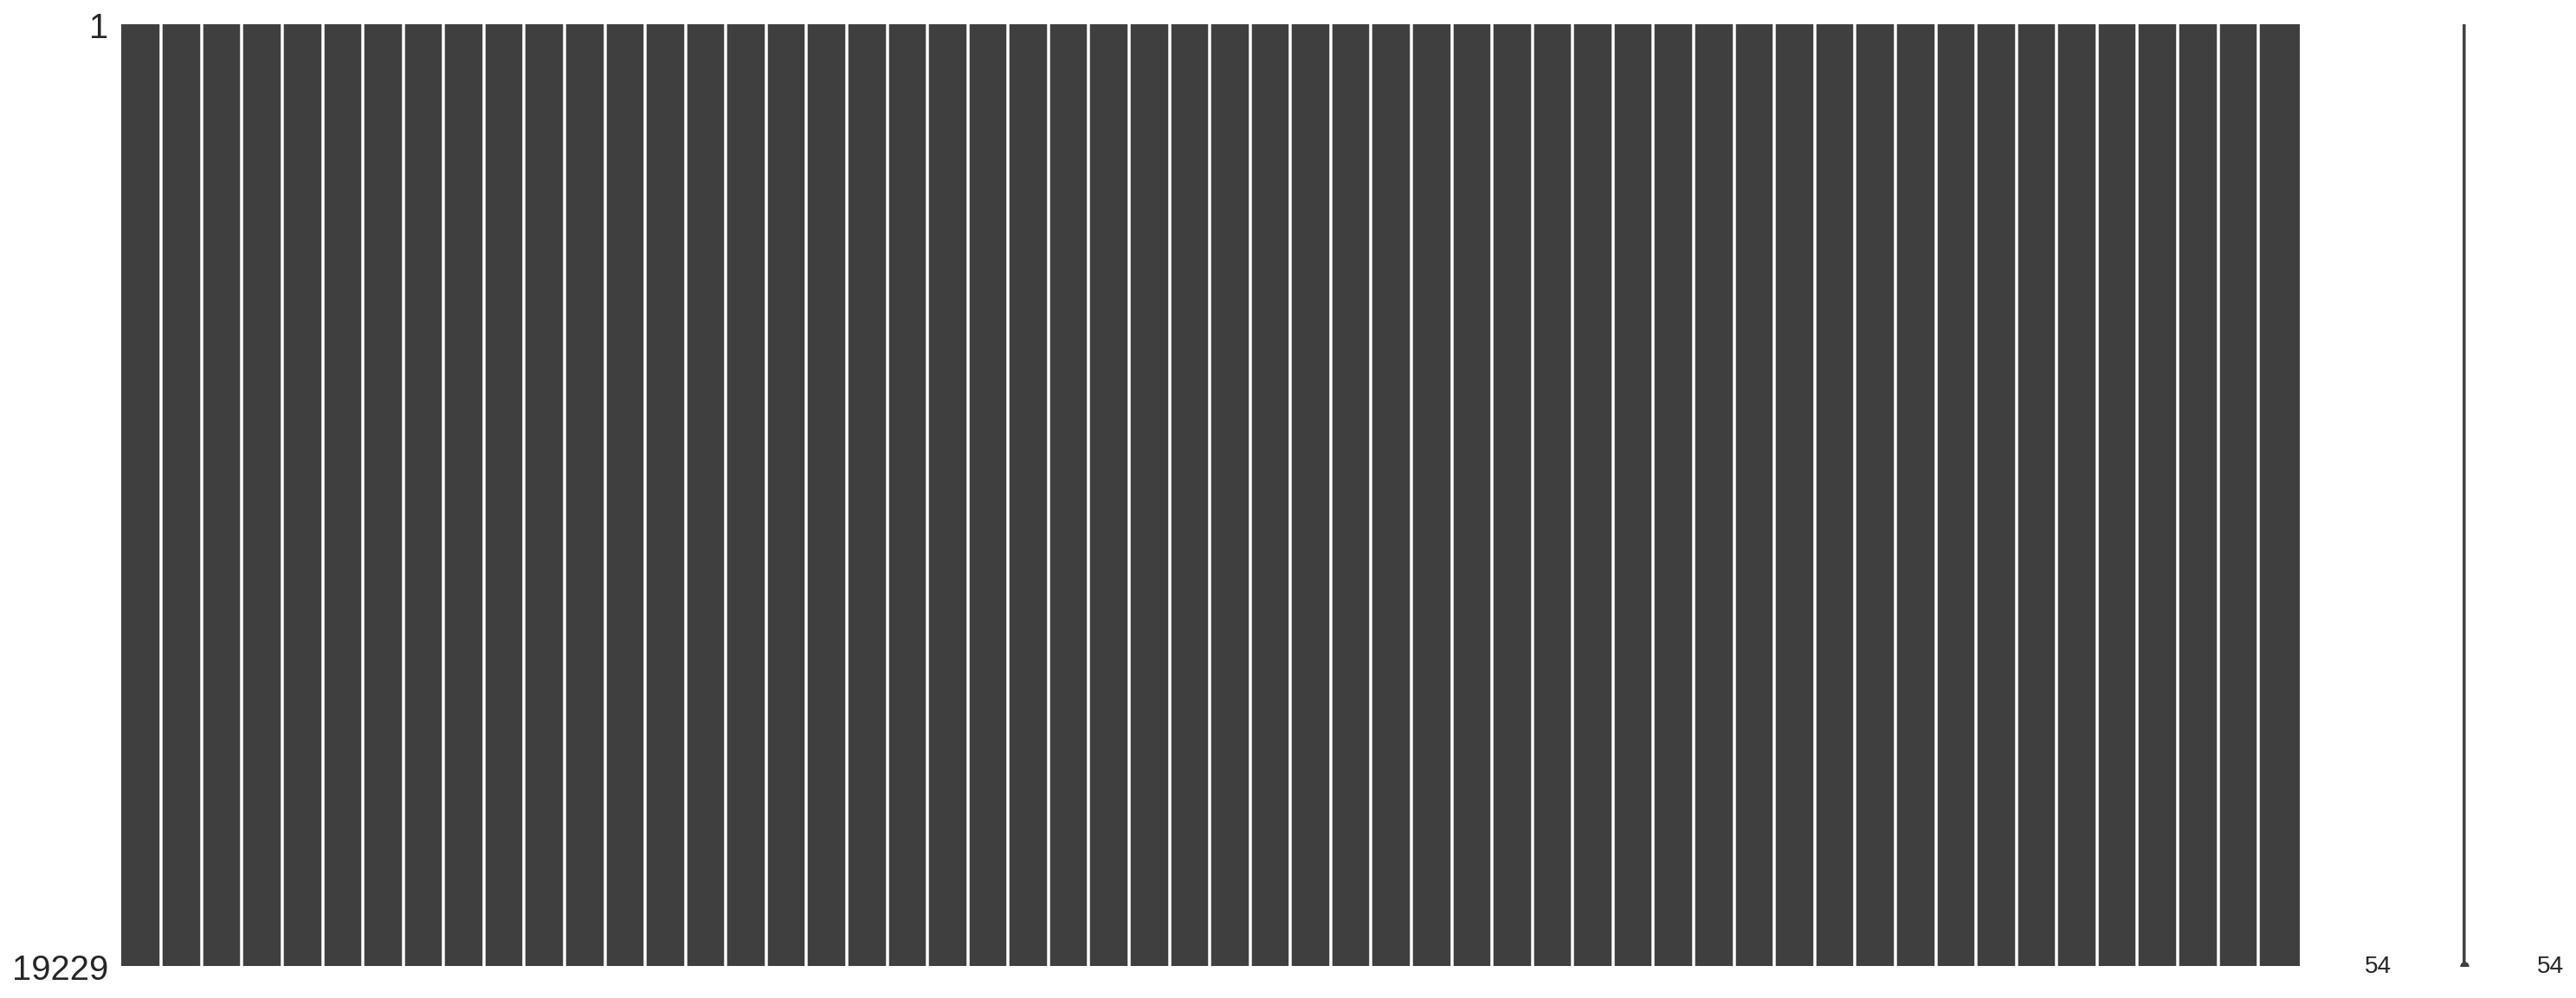

In [12]:
import missingno as msno

msno.matrix(pd.DataFrame(X_downsamp))

### Min/Max Distribution

Next up, checking for distribution of min/max values.

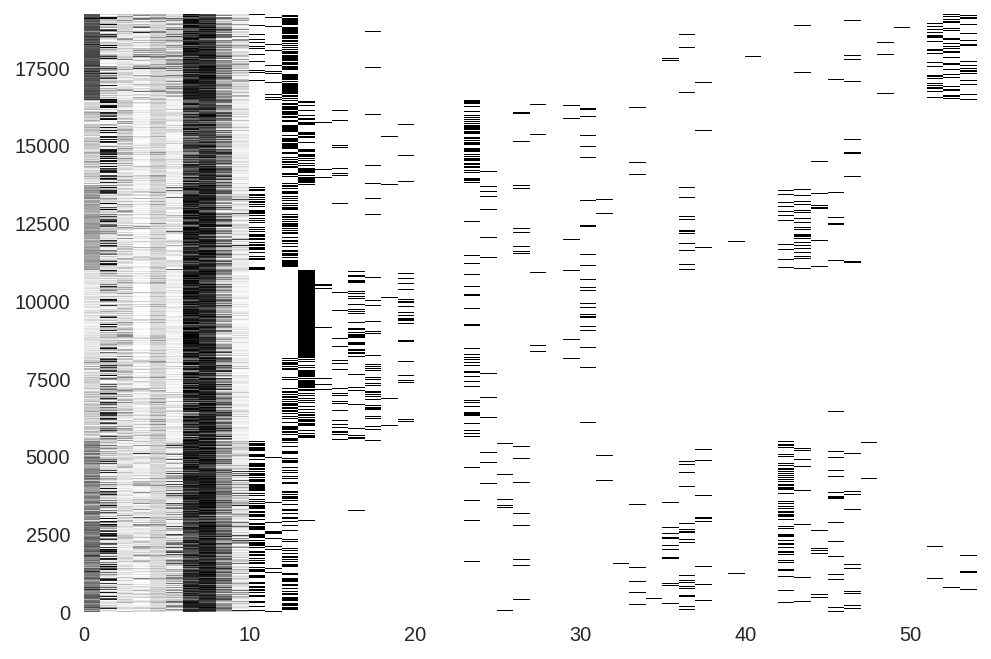

In [13]:
plt.pcolor(X_downsamp)

I am satisfied that the data have been normalized correctly, and are in the correct shape. The caveats of correlations between columns still remain, but I won't deal with them for now, as I just want to get multi-class logistic regression going first.

# Model Construction

I have chosen to do Bayesian logistic regression. In the original work, neural networks (NNs) were used. Because of the increased modelling capacity of NNs, I expect that they will perform better than Bayesian LR.

Nonetheless, as this is an exercise in implementing simple Bayesian models for others to use as a recipe for their own analyses, I will focus on model construction and critique, and not on model comparison. Thus, no cross-validation.

## Logit Function

With that said, let's move onto the model. Firstly, we define the logit function:

$$ logit(X) = \frac{1}{1 + e^{-X}} $$

In [14]:
def logit(X):
    return 1 / (1 + np.exp(-X))

A quick test that the logit function will indeed work with an array of numbers:

In [15]:
logit(np.array([1, 2, 1, 3]))

array([ 0.73105858,  0.88079708,  0.73105858,  0.95257413])

## Model Specification 

Now, we implement the model:

In [16]:
# Bayesian multi-class logistic regression to predict the target classes.
import theano.tensor as tt

with pm.Model() as model:
    weights_testval = np.random.randn(X_downsamp.shape[1], Y_downsamp.shape[1])
    weights = pm.Normal('weights', 0., 100., 
                        shape=(X_downsamp.shape[1], Y_downsamp.shape[1]))
    
    intercept = pm.Normal('intercept', 0., 100., shape=Y_downsamp.shape[1])

    exponent = tt.dot(X_downsamp, weights) + intercept
    p = logit(exponent)
    
    like = pm.Multinomial('likelihood', n=1, p=p, observed=np.asarray(Y_downsamp))


Some quick checks, with thanks to @junpenglao for providing this.

In [17]:
print(model.logp(model.test_point))
for RV in model.basic_RVs:
    print(RV.name, RV.logp(model.test_point))

-39544.6875
weights -2088.11328125
intercept -38.66876220703125
likelihood -37417.90625


In [18]:
with model:
    trace = pm.sample(20000, start=pm.find_MAP(), step=pm.Metropolis())

         Current function value: 15113.081055
         Iterations: 141
         Function evaluations: 169
         Gradient evaluations: 157


100%|██████████| 20500/20500 [00:33<00:00, 614.66it/s]


## Traces

Visualize the traces to check for convergence in sampling.

array([[<matplotlib.axes._subplots.AxesSubplot object at 0x7f2981e94160>,
        <matplotlib.axes._subplots.AxesSubplot object at 0x7f298065c278>]], dtype=object)

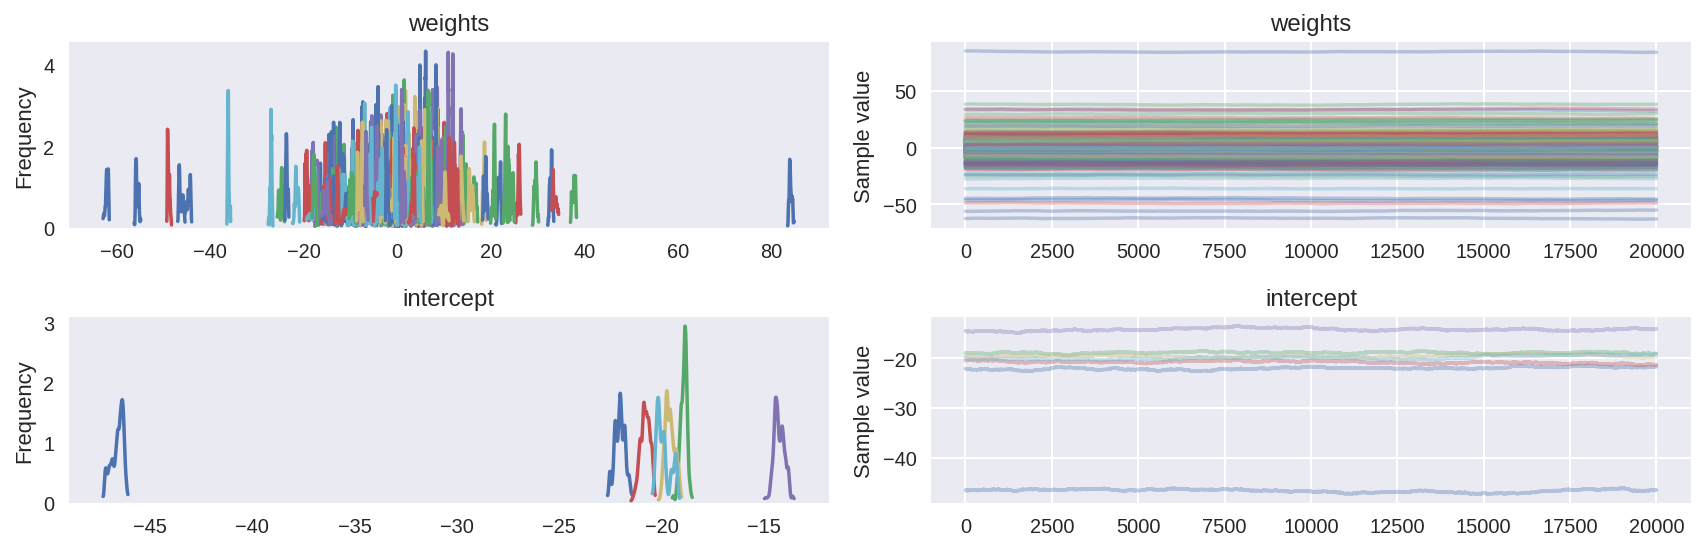

In [19]:
pm.traceplot(trace)

# Interpretation

Sampling is pretty good. No trends in the intercepts or weights. In fact, putting 7 intercept terms (one for each class) caused shrinkage (not in the Bayesian hierarchical sense) of the weights to be closer to zeros, which I think is a good sign.

# Model Evaluation

We will use posterior predictive checks to sample out new data from the posterior distributions of weights and intercepts. 

## Sample PPC

In [20]:
with model:
    ppc_samps = pm.sample_ppc(trace, samples=1000)

100%|██████████| 1000/1000 [00:37<00:00, 26.58it/s]


In [21]:
ppc_samps['likelihood'].shape

(1000, 19229, 7)

Because of multi-class classification, let's label the class that has the highest probability to be the predicted label.

In [22]:
probs = ppc_samps['likelihood'].mean(axis=0)
ppc_preds = (probs == np.max(probs, axis=1, keepdims=True))

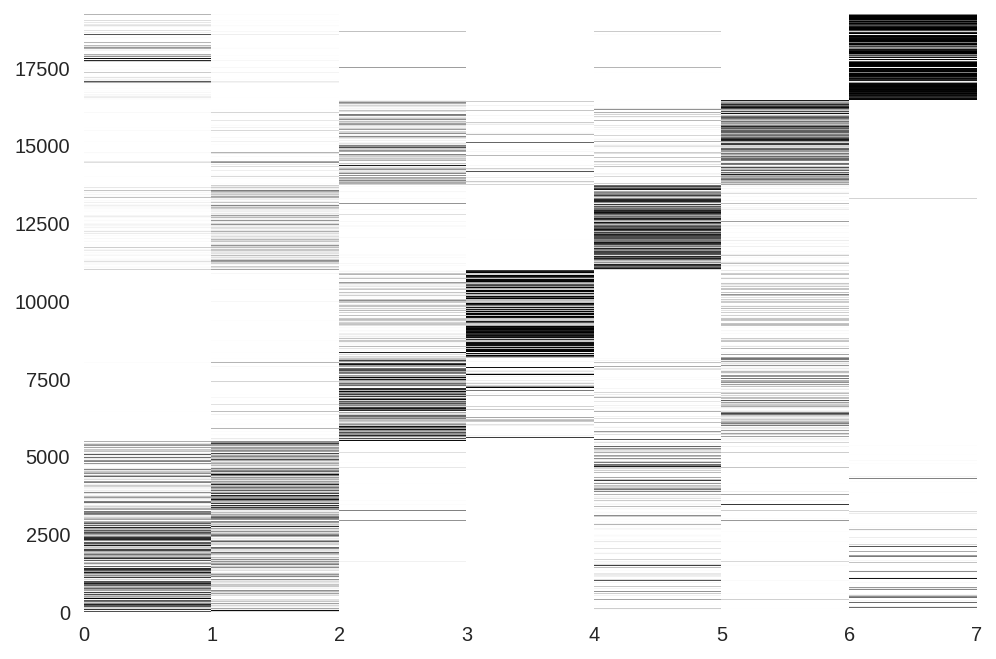

In [23]:
plt.pcolor(probs)

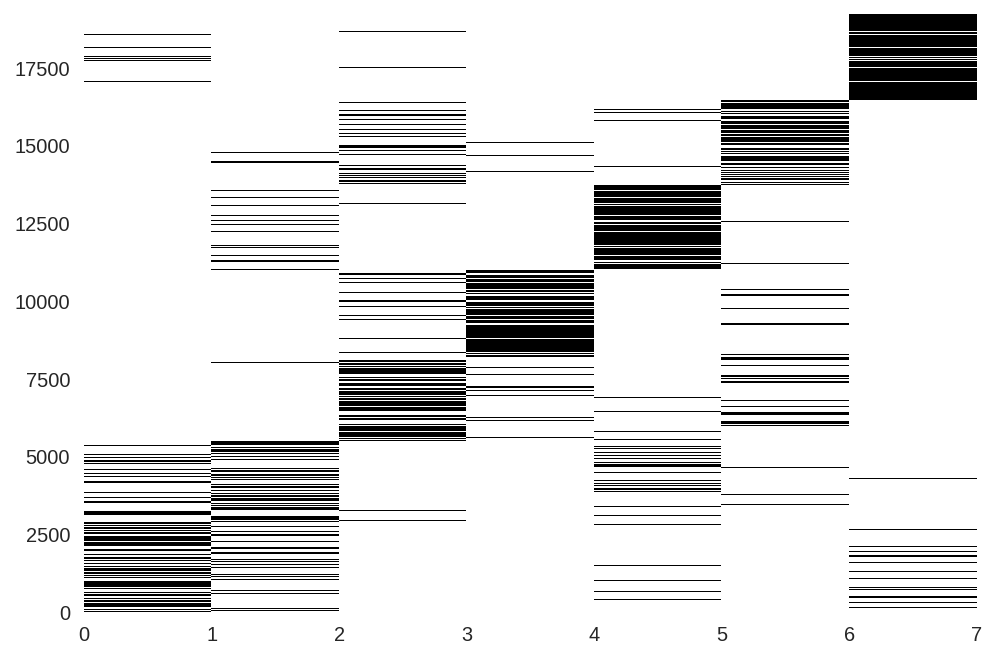

In [24]:
plt.pcolor(ppc_preds)

In [25]:
from scikitplot.plotters import plot_confusion_matrix
from sklearn.metrics import classification_report

## Classification Report

In [26]:
print(classification_report(Y_downsamp, ppc_preds))

             precision    recall  f1-score   support

          0       0.68      0.63      0.65      2747
          1       0.62      0.52      0.56      2747
          2       0.59      0.60      0.60      2747
          3       0.84      0.82      0.83      2747
          4       0.72      0.79      0.76      2747
          5       0.60      0.64      0.62      2747
          6       0.84      0.92      0.88      2747

avg / total       0.70      0.70      0.70     19229

